In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import timeit
from collections import Counter

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22, 'figure.figsize' : (40., 7.), 'lines.linewidth' : 3})

%load_ext autoreload
%autoreload 2

from MultiIndex import *
from Densities import *
from Surrogates import *
import legendreutil, plotutil, pointutil

rng = np.random.default_rng()

polys = legendreutil.get_polys(100)

def christoffel(x, multis) :
    return multis.size()/np.sum([np.prod([polys[k](x[j])**2 for j,k in enumerate(multis[i].asList())]) for i in range(multis.size())])

def chebychev(x) :
    return np.pi * np.sqrt(1-x**2)

def plot_random(ax, n, arr, label) :
    #print(n.shape, n[-1,:])
    c = ax.plot(n, np.nanmean(arr,axis=1), lw=3, label=label)
    ax.fill_between(n, np.nanmin(arr,axis=1), np.nanmax(arr,axis=1), color=c[0].get_color(), alpha=.2)

def plot_row(*, fig, nx, i, runs, n_t=None, print_final=False) :
    axs = [plotutil.get_ax(fig=fig, nx=nx, ny=8, idx=j, logaxis=['x', 'y'], xlabel='n', title=t) for j, t in zip(range(i, i+8*nx, nx),[r'$\sigma_{min}(L)$', r'$\sigma_{max}(L)$', r'$\kappa(L)$', r'$\sigma_{min}(G)$', r'$\sigma_{max}(G)$', r'$\kappa(G)$', r'$d_H$', r'$n$'])]
    for mode in runs.keys() :
        if runs[mode] is None : continue
        if print_final : print(i, mode, '\t', runs[mode].shape[1], '\t', np.nanmean(runs[mode][-1,:,3]/runs[mode][-1,:,2]))
        plot_random(axs[0], runs[mode][:,0,4], runs[mode][:,:,0], mode)
        plot_random(axs[1], runs[mode][:,0,4], runs[mode][:,:,1], mode)
        plot_random(axs[2], runs[mode][:,0,4], runs[mode][:,:,1]/runs[mode][:,:,0], mode)
        plot_random(axs[3], runs[mode][:,0,4], runs[mode][:,:,2], mode)
        plot_random(axs[4], runs[mode][:,0,4], runs[mode][:,:,3], mode)
        plot_random(axs[5], runs[mode][:,0,4], runs[mode][:,:,3]/runs[mode][:,:,2], mode)
        plot_random(axs[6], runs[mode][:,0,4], runs[mode][:,:,5], mode)
        plot_random(axs[7], runs[mode][:,0,4], runs[mode][:,:,6], mode)
        axs[0].legend()
    #if n_t is not None : ax.vlines(n_t, 1,10, lw=3, color='r')
    
def get_properties(n, mode, multis) :
    #samples = get_samples(n, mode, multis)
    #weights = np.pi/2 * np.prod(np.sqrt(1-samples**2), axis=0)
    #L = legendreutil.evaluate_basis(samples, multis)
    #for ii in range(L.shape[0]) : L[ii,:] *= np.sqrt(weights[ii])
    #G = np.dot(L.T, L)/L.shape[0] - np.eye(multis.size())
    
    #t = None
    #if multis.dim == 1 :
    #t = Gaussian1D(mean=randutil.points(multis.dim,1), cova=randutil.covarm(multis.dim), save=False)
    #else :
    t = Gaussian(mean=randutil.points(multis.dim,1), cova=randutil.covarm(multis.dim), save=False)
    s = Legendre(multis=multis, target=t, pmode=mode, n=n, save=False)
    
    L_svd = np.linalg.svd(s.L, compute_uv=False)
    G_svd = np.linalg.svd(s.G, compute_uv=False)
    
    e = s.computeError()
    
    return min(L_svd), max(L_svd), min(G_svd), max(G_svd), s.L.shape[0], e.hedist, e.nevals

def get_properties_run(multis, mode, n, trials=1, res_old=None) :
    if mode == '1d_det' :
        if res_old is not None : return n, res_old
        else : trials = 1
    res = np.zeros((len(n),trials,7))
    for i,ni in enumerate(n) :
        if mode == 'sparse_grid' : print(ni.getSparseGridSize(), end=' ')
        else : print(ni, end=' ')
        for j in range(trials) :
            try :
                res[i,j] = get_properties(ni, mode, multis)
            except RuntimeError :
                pass
    print('Done')
    if mode == 'cheby_ss' :
        c = Counter([n for n in sorted(res[:,:,4].flatten()) if n != 0])
        r = np.zeros((len(c),c.most_common(1)[0][1], 7))
        r[:] = np.NaN
        for i,ci in enumerate(c.items()) : 
            for j, idx in enumerate(np.argwhere(res[:,:,4] == ci[0])) :
                r[i, j, :] = res[idx[0],idx[1],:]
        res = r
    if res_old is None :
        return res
    print(res_old.shape, res.shape)
    return np.concatenate((res_old, res), axis=1)

get_properties(20, 'uni', SparseSet.withSize(weights=[.7], n=9, t=60))

/home/uq/.local/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/home/uq/.local/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: overflow encountered in scalar power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/uq/.local/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


(array([0.39000139]), array([0.00933049]), 5)


(0.047219164089755294,
 4.400502713289654,
 0.031778793516518716,
 0.9998885175271331,
 20,
 0.031843503941524035,
 100)

# Legendre Polynomials

In [2]:
x = np.linspace(-1, 1, 200)
fig = plt.figure()
ax1 = plotutil.get_ax(fig, nx=2, idx=1)
ax2 = plotutil.get_ax(fig, nx=2, idx=2)
for k in range(6) :
    ax1.plot(x, polys[k](x), label=str(k))         # 2 * np.pi * np.sqrt(1 - x**2) * (np.cos(k*np.arccos(x))**2)
    ax2.plot(x, polys[k](x)**2, label=str(k))      # 2 * np.pi * np.sqrt(1 - x**2) * polys[k](x)**2
plt.legend(); plt.show()

TypeError: get_ax() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given

<Figure size 4000x700 with 0 Axes>

# Chebychev Weight vs Christoffel Weight

Why do we rely on random points for weighted least squares?
Theory: Optimal sampling measure, density is Christoffel function
Optimal sampling measure has structure - minima at Chebychev points

Experiments: evaluate condition number for random and deterministic points (over #samples)
WLS Theory: need 10*m*log(m) samples for reasonable condition number

5
[(0,), (1,), (2,), (3,), (4,)]


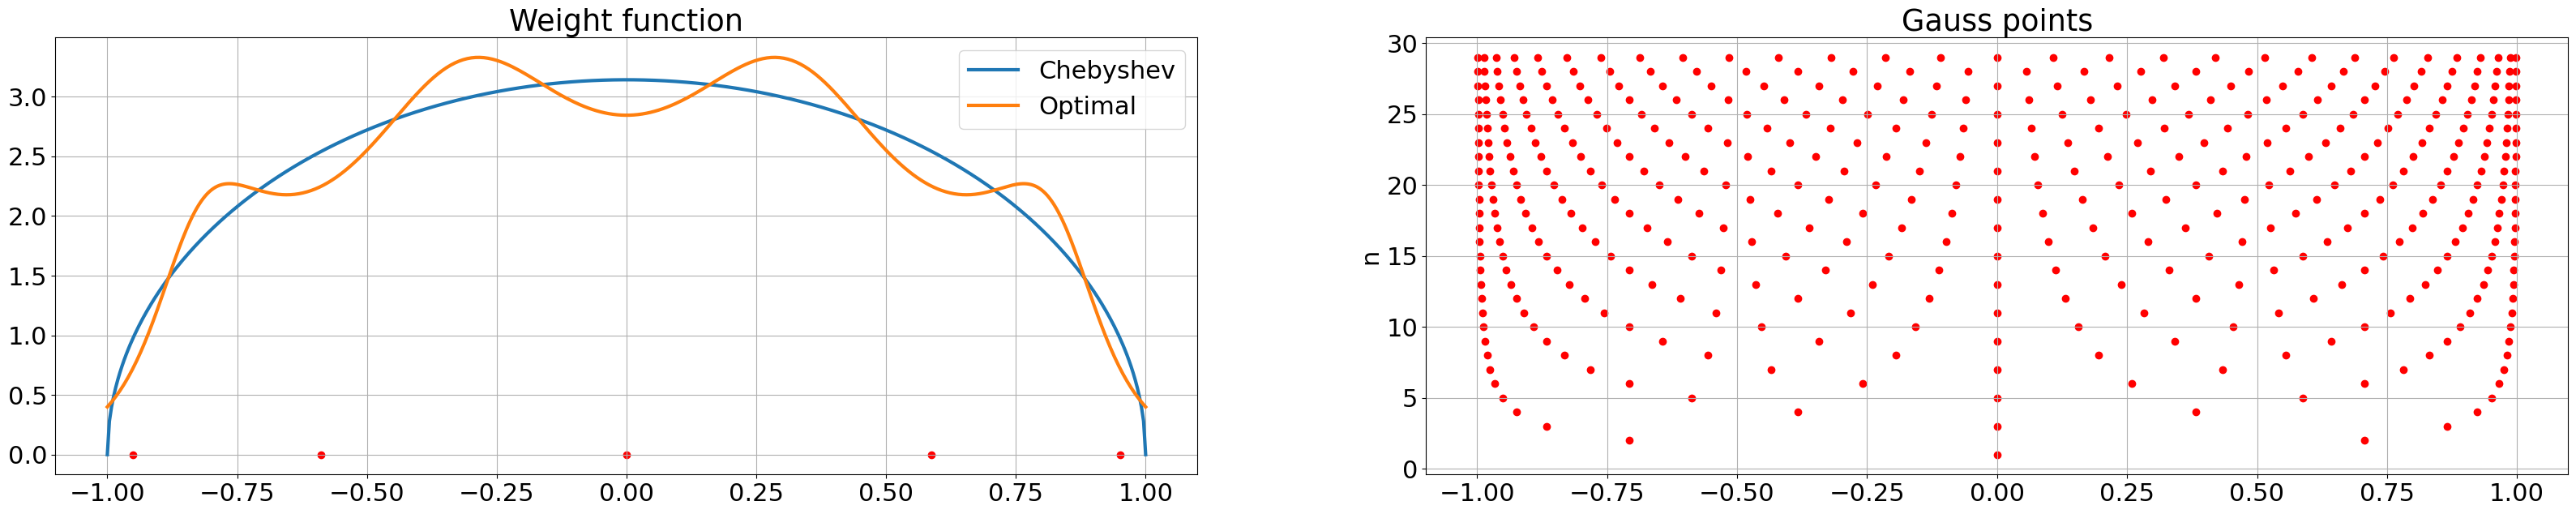

In [8]:
x = np.linspace(-1, 1, 500)
kmax = 5
multis = TotalDegreeSet(dim=1, order=kmax-1)
print(multis.size())
print(multis.asLists())

fig = plt.figure()
ax = plotutil.get_ax(fig=fig, nx=2, idx=1, title='Weight function')
ax.plot(x, chebychev(x), lw=3, label='Chebyshev')
ax.plot(x, [christoffel([xi], multis) for xi in x], lw=3, label='Optimal')
ax.scatter(gauss_points(kmax), [0]*kmax, c='r')
plt.legend()
ax = plotutil.get_ax(fig=fig, nx=2, idx=2, title='Gauss points', ylabel='n')
for i in range(1,30) :
    ax.scatter(gauss_points(i), [i]*i, c='r')
plt.show()

In [33]:
multis = SparseSet.withSize(weights=[.7, .5], n=9, t=60)
x = np.linspace(-1,1,200)
X,Y = np.meshgrid(x,x)
Z = np.array([[christoffel([X[i,j], Y[i,j]], multis) for j in range(len(x))] for i in range(len(x))])
Z_cheb = np.array([[chebychev(X[i,j])*chebychev(Y[i,j]) for j in range(len(x))] for i in range(len(x))])
print(multis.asLists())

[array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([0, 1]), array([1, 1]), array([2, 1]), array([0, 2])]


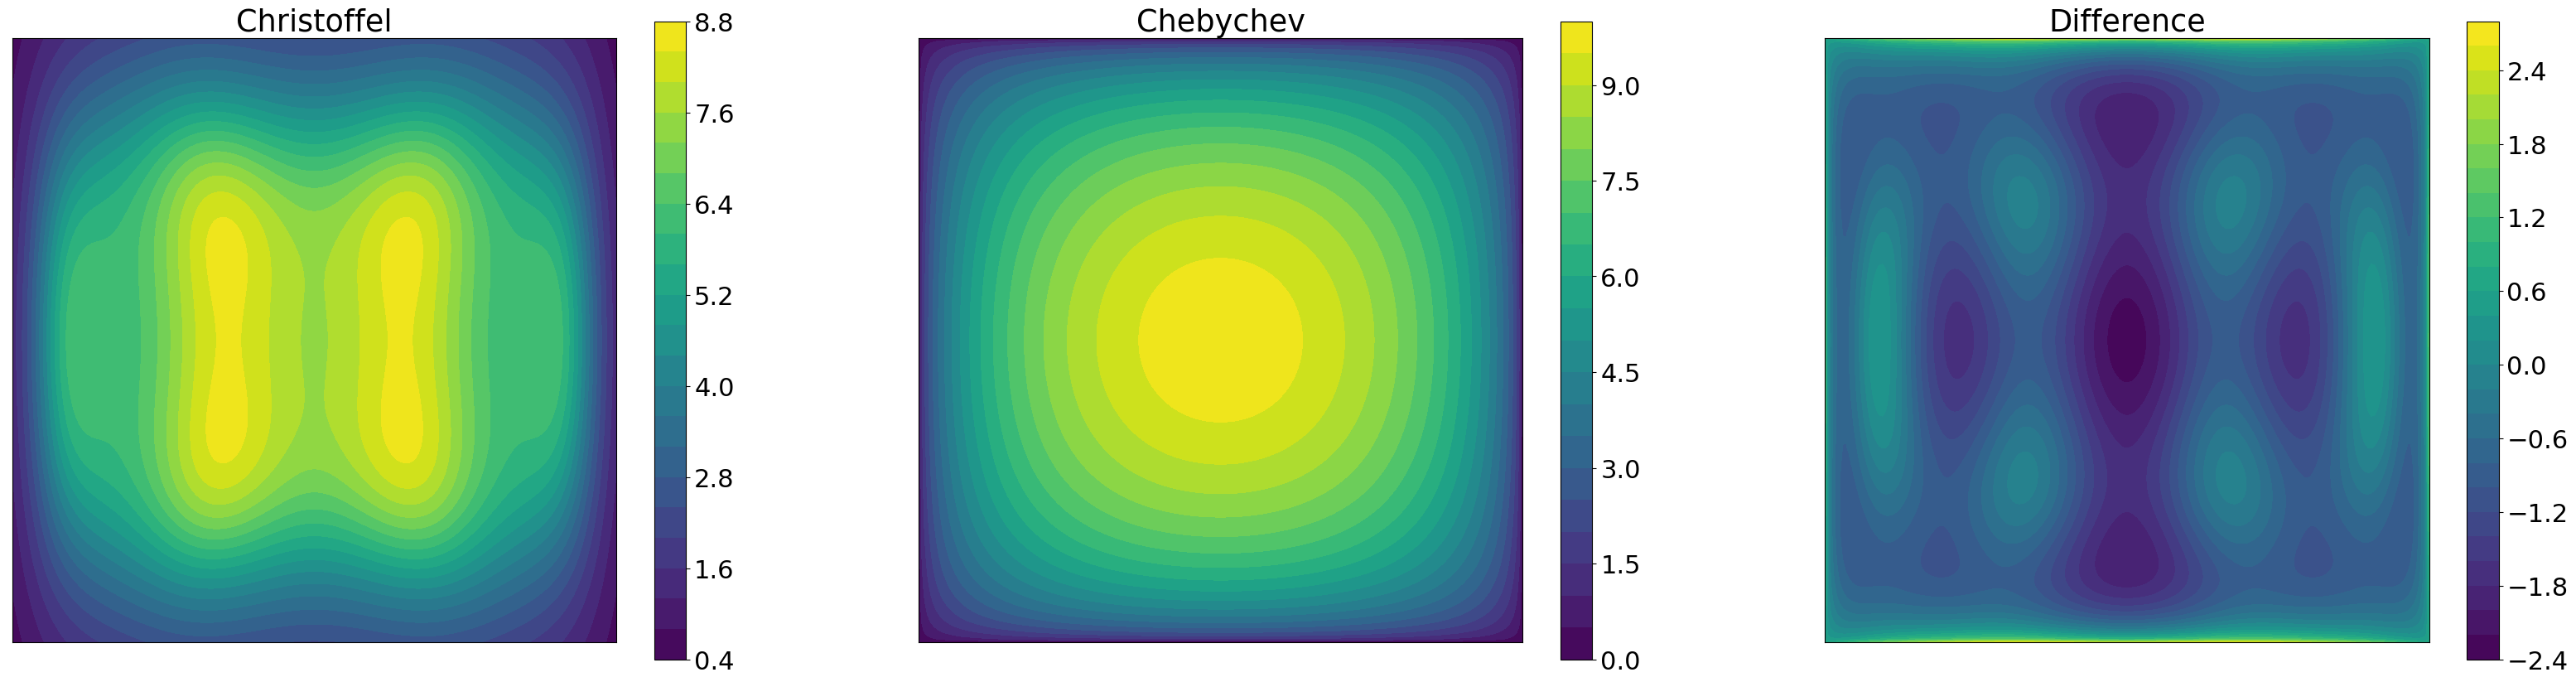

In [34]:
fig = plt.figure(figsize=(40,10))
ax = plotutil.get_ax(fig, nx=3, idx=1, square=True, xlabel='', title='Christoffel')
plt.colorbar(ax.contourf(X, Y, Z, levels=20))
ax = plotutil.get_ax(fig, nx=3, idx=2, square=True, xlabel='', title='Chebychev')
plt.colorbar(ax.contourf(X, Y, Z_cheb, levels=20))
ax = plotutil.get_ax(fig, nx=3, idx=3, square=True, xlabel='', title='Difference')
plt.colorbar(ax.contourf(X, Y, Z-Z_cheb, levels=30))
plt.show()

# Condition Number of WLS: Random vs Gauss Points

<font size="5">Let $n = $ number of points and $m = |\Lambda|$.

<font size="5">$L \in \mathbb{R}^{n \times m}$, $L_{kj} = L_k (\chi_j)$

<font size="5">$G \in \mathbb{R}^{m \times m}$, $G = \frac{1}{n} L^\top L$, $G_{ij} = \langle L_i, L_j \rangle_n = \sum_k L_i(\chi_k) L_j(\chi_k)$

## Choices of point sets

(2, 1000)
(2, 1000)


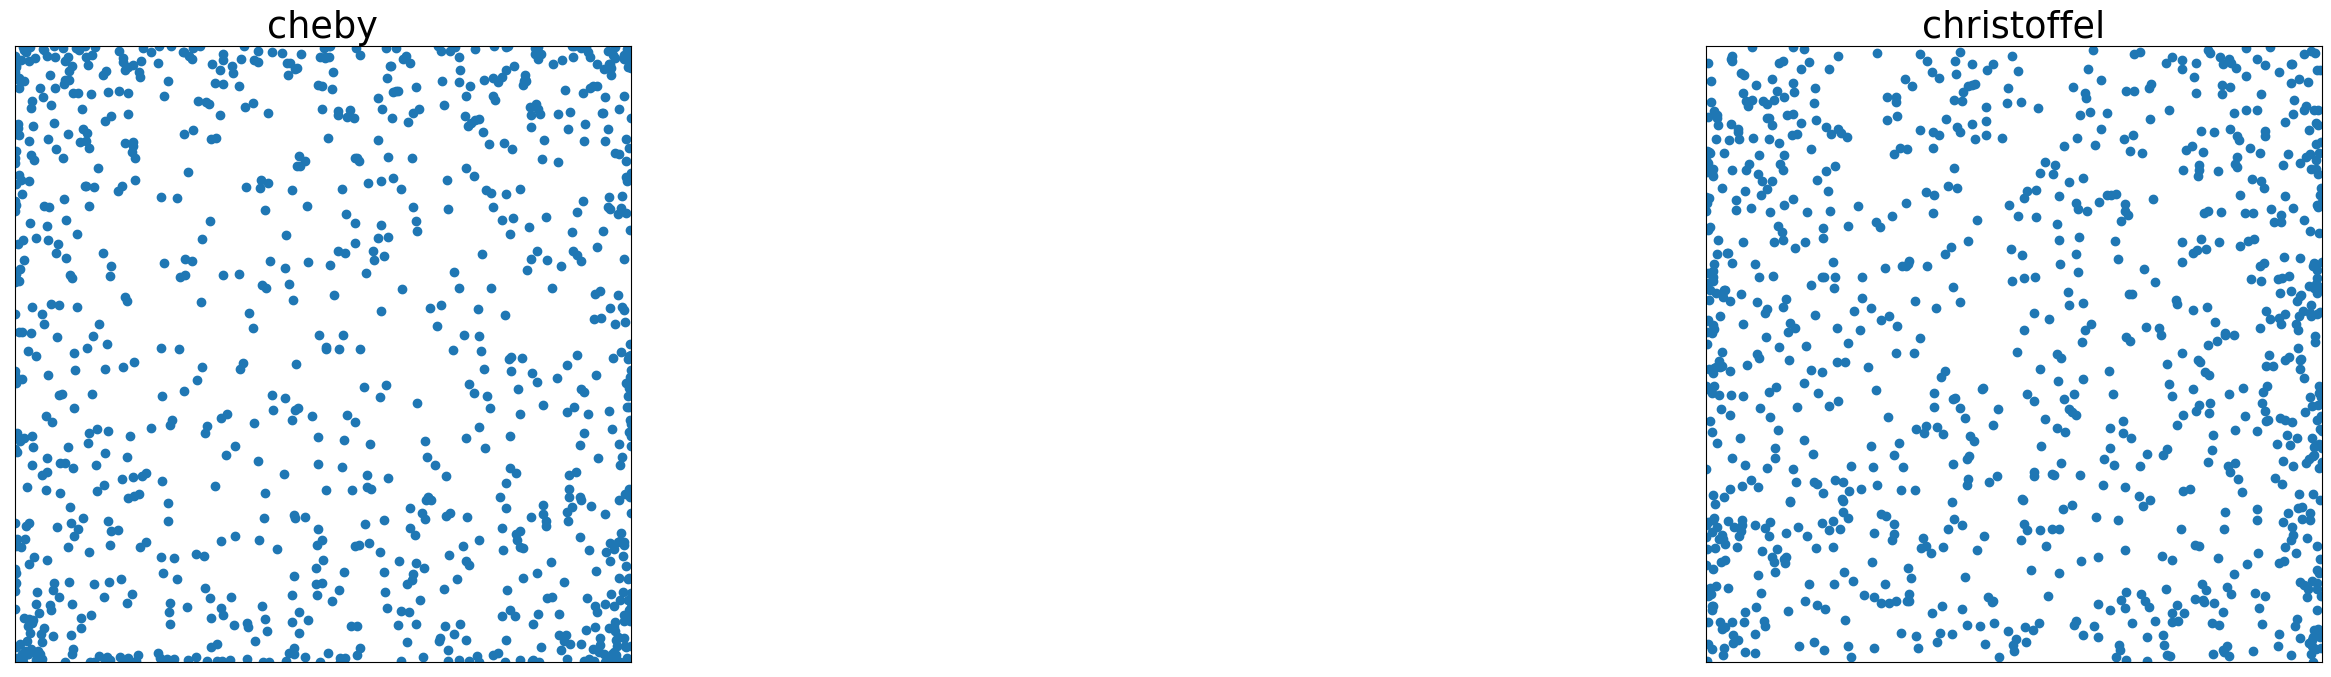

In [36]:
n = 1000
m = SparseSet.withSize(weights=[.8, .2], n=10, t=60)
fig = plt.figure(figsize=(40,8))
modes = ['cheby', 'christoffel']
for i,mode in enumerate(modes) :
    ax = plotutil.get_ax(fig=fig, nx=len(modes), idx=i+1, square=True, title=mode, xlabel='')
    n = SparseSet.withSize(weights=[.6, .4], n=27, t=60) if mode == 'sparse_grid' else n
    x, _ = pointutil.get_sample_points_and_weights(m, mode, n=n)
    print(x.shape)
    ax.scatter(x[0], x[1])
plt.show()

## Runs

In [3]:
4**4

256

In [14]:
n_standard = list(range(10,30,1)) + list(range(30,50,2)) + list(range(50,100,3)) + list(range(100,200,5)) + list(range(200,310,10))
res = {1 : {'multis' : TotalDegreeSet(dim=1,order=9),                            'runs' : {'cheby' : None, 'cheby_ss' : None, 'tp_light' : None}}, 
       2 : {'multis' : TotalDegreeSet(dim=2,order=3),                            'runs' : {'cheby' : None, 'cheby_ss' : None, 'tp_light' : None, 'shuffled' : None}},
       3 : {'multis' : SparseSet.withSize(weights=[.6, .4], n=10, t=60),         'runs' : {'cheby' : None, 'cheby_ss' : None, 'tp_light' : None, 'shuffled' : None, 'sparse_grid' : None}},
       4 : {'multis' : SparseSet.withSize(weights=[.6, .4, .3, .1], n=15, t=60), 'runs' : {'cheby' : None, 'cheby_ss' : None, 'tp_light' : None, 'shuffled' : None, 'sparse_grid' : None}}}

In [15]:
i = 1
mode = 'tp_light'
trials = 1
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [48]:
res[2]['runs']['sparse_grid'] = None

In [16]:
i = 1
mode = 'cheby'
trials = 50
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [17]:
i = 1
mode = 'cheby_ss'
trials = 50
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [18]:
i = 2
mode = 'cheby'
trials = 50
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [19]:
i = 2
mode = 'cheby_ss'
trials = 50
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [20]:
i = 2
mode = 'shuffled'
trials = 10
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [21]:
i = 2
mode = 'tp_light'
trials = 10
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [22]:
i = 3
mode = 'cheby'
trials = 10
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [23]:
i = 3
mode = 'cheby_ss'
trials = 10
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [24]:
i = 3
mode = 'tp_light'
trials = 10
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [25]:
i = 3
mode = 'shuffled'
trials = 10
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [26]:
i = 3
mode = 'sparse_grid'
n_sparse = [SparseSet.withSize(weights=[.6, .4], n=ni, t=60) for ni in range(10,50)]
trials = 1
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_sparse, trials=trials, res_old=res[i]['runs'][mode])

24 27 28 35 40 43 44 51 56 59 60 69 76 81 84 85 94 101 106 109 120 121 130 137 142 145 156 157 166 173 178 191 194 205 206 215 222 227 240 243 Done


In [44]:
i = 4
mode = 'cheby'
trials = 30
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done
(78, 20, 7) (78, 30, 7)


In [41]:
i = 4
mode = 'cheby_ss'
trials = 100
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done


In [42]:
i = 4
mode = 'tp_light'
trials = 40
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done
(78, 10, 7) (78, 40, 7)


In [43]:
i = 4
mode = 'shuffled'
trials = 40
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_standard, trials=trials, res_old=res[i]['runs'][mode])

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 36 38 40 42 44 46 48 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 210 220 230 240 250 260 270 280 290 300 Done
(78, 10, 7) (78, 40, 7)


In [31]:
i = 4
mode = 'sparse_grid'
n_sparse = [SparseSet.withSize(weights=[.6, .4, .3, .1], n=ni, t=60) for ni in range(10,60)]
trials = 1
res[i]['runs'][mode] = get_properties_run(res[i]['multis'], mode, n=n_sparse, trials=trials, res_old=res[i]['runs'][mode])

24 25 32 32 33 40 43 49 50 59 58 65 64 73 74 81 93 94 105 110 108 118 126 126 137 136 144 146 163 164 168 181 190 194 191 204 213 213 226 223 240 249 244 266 267 268 277 292 305 324 Done


## Results

plot_row(fig=plt.figure(figsize=(40,6*8)), nx=2, i=1, runs=res[1]['runs'], print_final=True)
plot_row(fig=plt.figure(figsize=(40,6*8)), nx=2, i=2, runs=res[2]['runs'], print_final=True)
plt.tight_layout(); plt.show()

TotalDegreeSet(dim=1,order=9) | TotalDegreeSet(dim=2,order=3) | SparseSet.withSize(weights=[.6, .4], n=10) | SparseSet.withSize(weights=[.6, .4, .3, .1], n=15)
1 cheby 	 50 	 11.839841499017371
1 cheby_ss 	 72 	 7.80277957906893
1 tp_light 	 1 	 3.8390243150266907
2 cheby 	 50 	 1.2294535779078468
2 cheby_ss 	 78 	 1.224549469672856
2 tp_light 	 10 	 1.1824447432788179
2 shuffled 	 10 	 1.1946948137739364
3 cheby 	 10 	 1.215526272733968
3 cheby_ss 	 20 	 1.2119126712121508
3 tp_light 	 10 	 1.1881779067659546
3 shuffled 	 10 	 1.2097261917925406
4 cheby 	 50 	 1.013816602754954
4 cheby_ss 	 130 	 1.0193064568273185
4 tp_light 	 50 	 1.0136230162324689
4 shuffled 	 50 	 1.0132723430014436


/tmp/ipykernel_14237/3257983430.py:47: RuntimeWarning: divide by zero encountered in divide
  plot_random(axs[2], runs[mode][:,0,4], runs[mode][:,:,1]/runs[mode][:,:,0], mode)


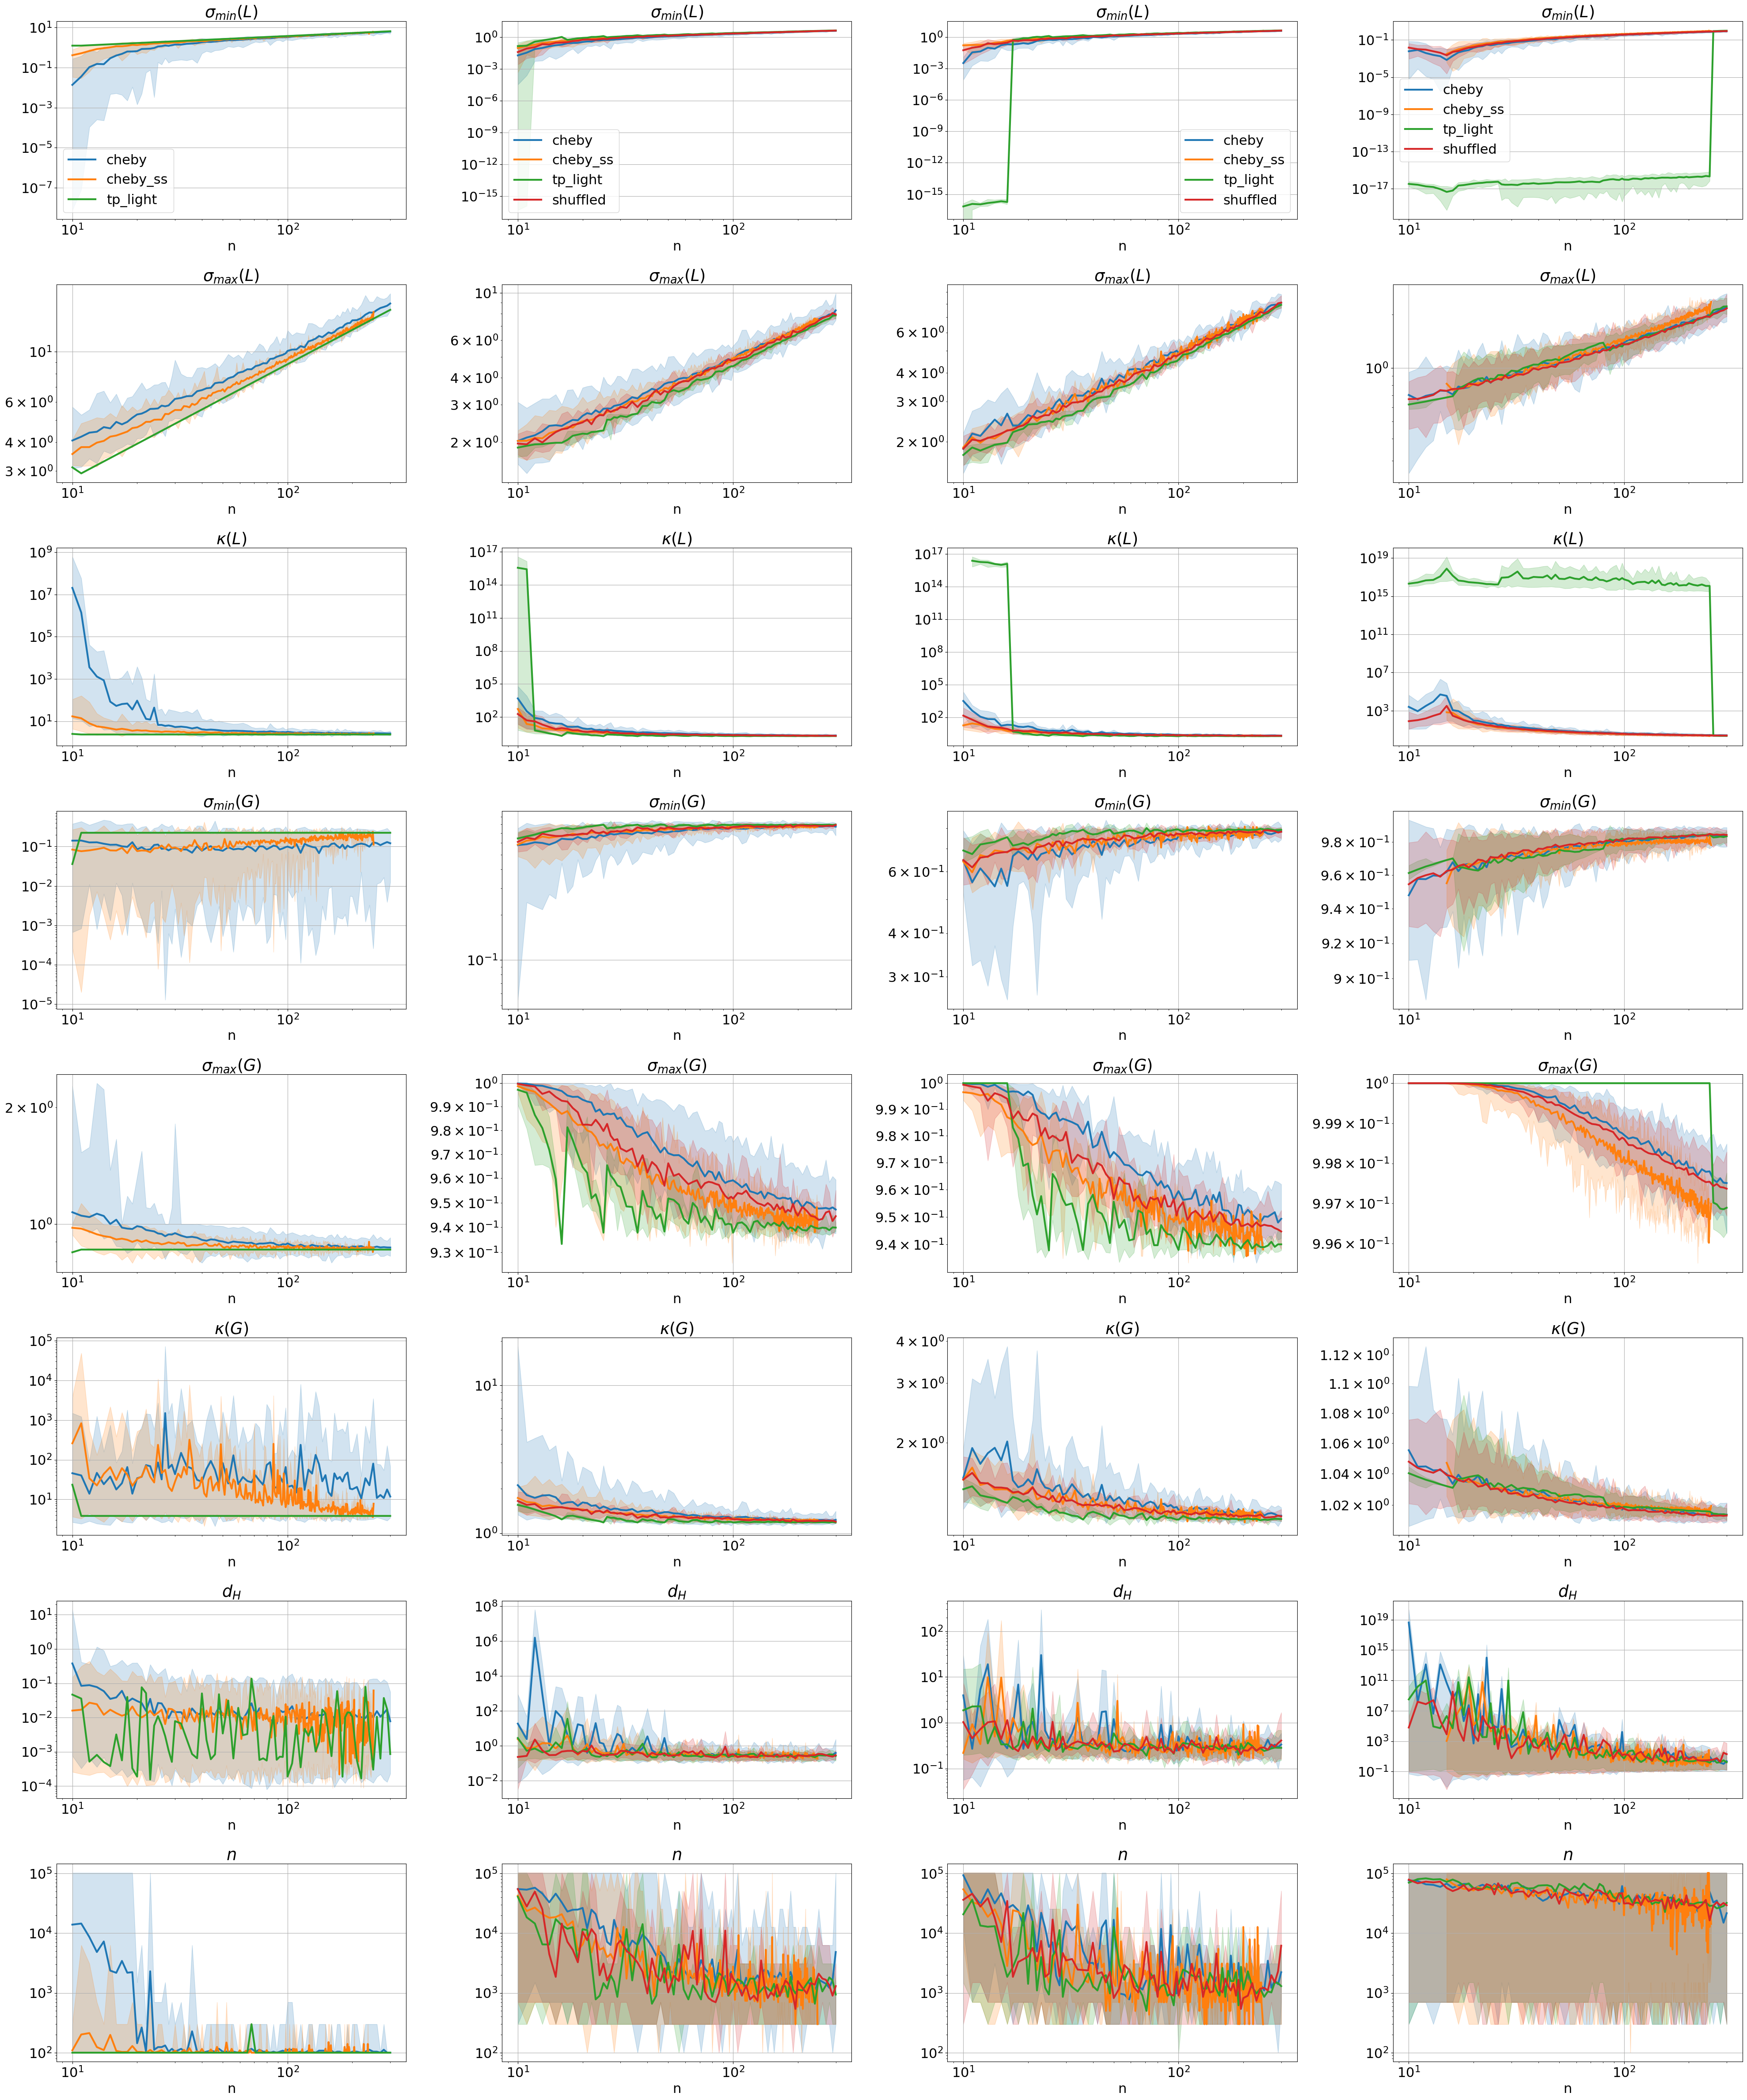

In [49]:
print('TotalDegreeSet(dim=1,order=9) | TotalDegreeSet(dim=2,order=3) | SparseSet.withSize(weights=[.6, .4], n=10) | SparseSet.withSize(weights=[.6, .4, .3, .1], n=15)')

fig = plt.figure(figsize=(40,6*8))
n = len(res.keys())
for i in range(1, n+1) :
    plot_row(fig=fig, nx=n, i=i, runs=res[i]['runs'], print_final=True)
plt.tight_layout(); plt.show()

### Observations

* 

## Statistics of random points

In [74]:
for i in range(5) :
    samples = None
    cond = np.infty
    while cond > 1.35 :
        samples = np.sin(np.random.uniform(low=-3*np.pi/2, high=np.pi/2, size=(d, 10 * m * int(np.log(m)))))
        _, _, a, b = get_properties(samples, multis)
        cond = b/a
    print(cond)
    s = np.concatenate((s, samples), axis=None)

1.315321056739707
1.3174835088873025
1.3469228799880888
1.3425706814850762
1.3439680911374081


## 2D

In [10]:
kmax = 10 * m * int(np.log(m))
nodes = np.array([np.cos((2*k+1)*np.pi/2/kmax) for k in range(kmax)])

In [58]:
multis = TotalDegreeSet(dim=2,order=6)
m = multis.size()
trials = 100

n = np.logspace(start=np.ceil(np.log(m**(1/multis.dim))), stop=np.log((30 * m * int(np.log(m)))**(1/multis.dim)), num=20, dtype=int, base=np.exp(1))
print(n)
c_rand = np.zeros((len(n),trials,4))
c_det = np.zeros((len(n),4))
for i in range(len(n)) :
    c_det[i] = get_properties(n[i], True, multis)
    for j in range(trials) :
        c_rand[i,j] = get_properties(n[i], False, multis)

[ 7  8  9  9 11 12 13 14 16 18 20 22 24 27 30 33 37 41 45 50]


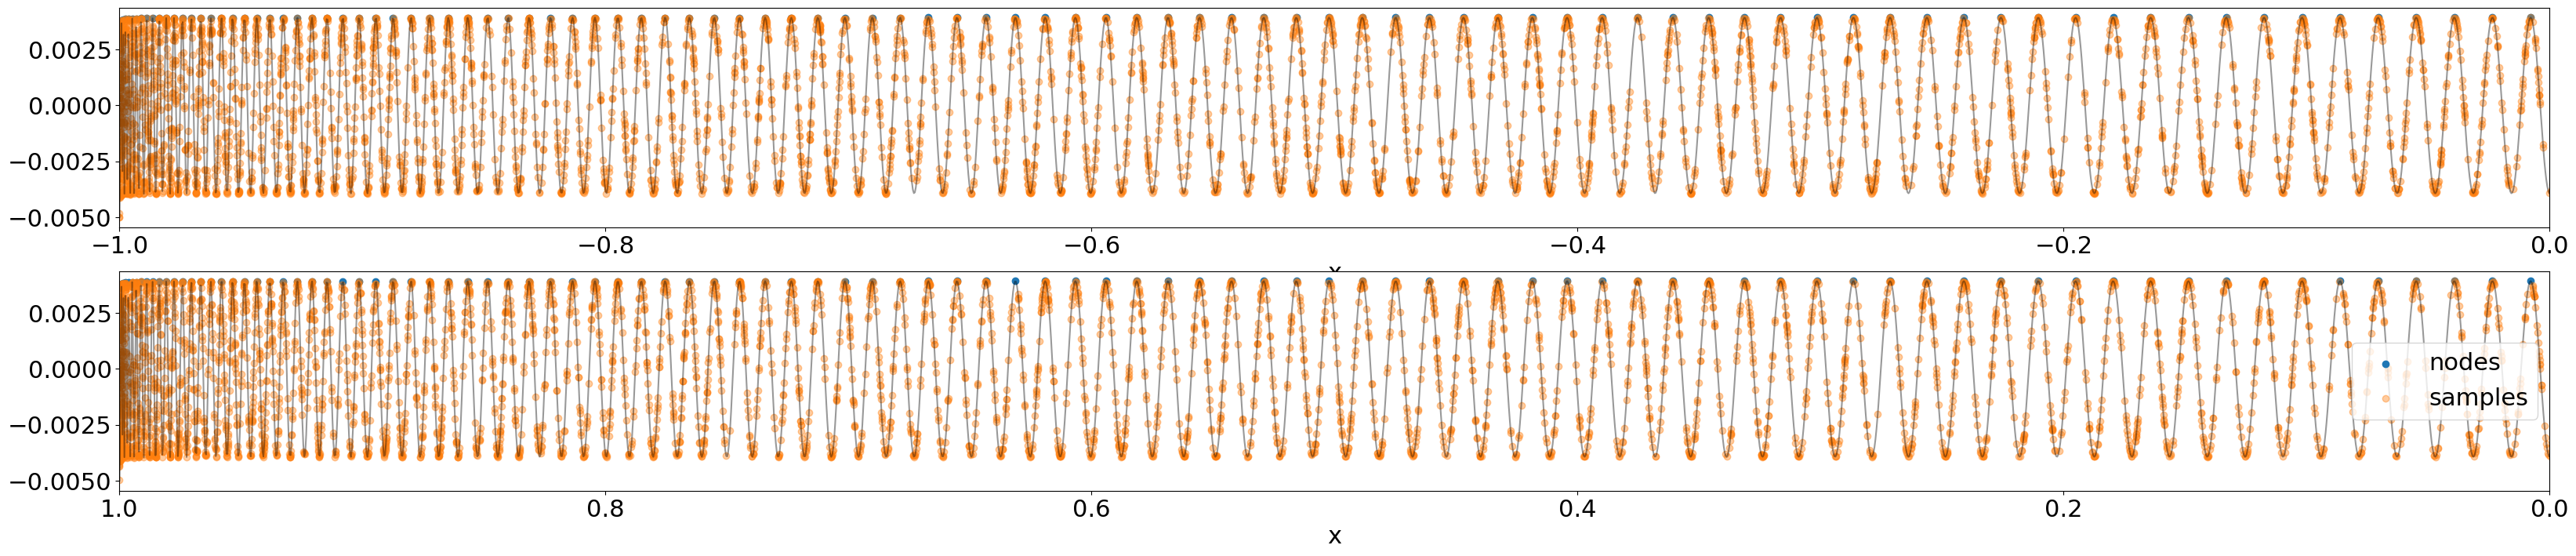

In [55]:
x = np.linspace(-1,1,5000)
c = np.pi/2 * np.sqrt(1-x**2)
o = [kmax/christoffel(xi, kmax) for xi in x]

fig = plt.figure(figsize=(40,8))
ax = plotutil.get_ax(fig, nx=1, ny=2, idx=1, title='')
ax.plot(x,c-o, 'k', alpha=.4)
ax.scatter(nodes, [np.pi/2 * np.sqrt(1-n**2) - kmax/christoffel(n, kmax) for n in nodes], label='nodes')
ax.scatter(s, [np.pi/2 * np.sqrt(1-n**2) - kmax/christoffel(n, kmax) for n in s], label='samples', alpha=.4)
ax.set_xlim([-1,0])
ax.grid()
ax = plotutil.get_ax(fig, nx=1, ny=2, idx=2, title='')
ax.plot(x,c-o, 'k', alpha=.4)
ax.scatter(nodes, [np.pi/2 * np.sqrt(1-n**2) - kmax/christoffel(n, kmax) for n in nodes], label='nodes')
ax.scatter(s, [np.pi/2 * np.sqrt(1-n**2) - kmax/christoffel(n, kmax) for n in s], label='samples', alpha=.4)
ax.set_xlim([0,1])
plt.gca().invert_xaxis()
plt.grid()
plt.legend()
plt.show()

In [61]:
10*m*np.log(m), 50**2

(933.017262849057, 2500)

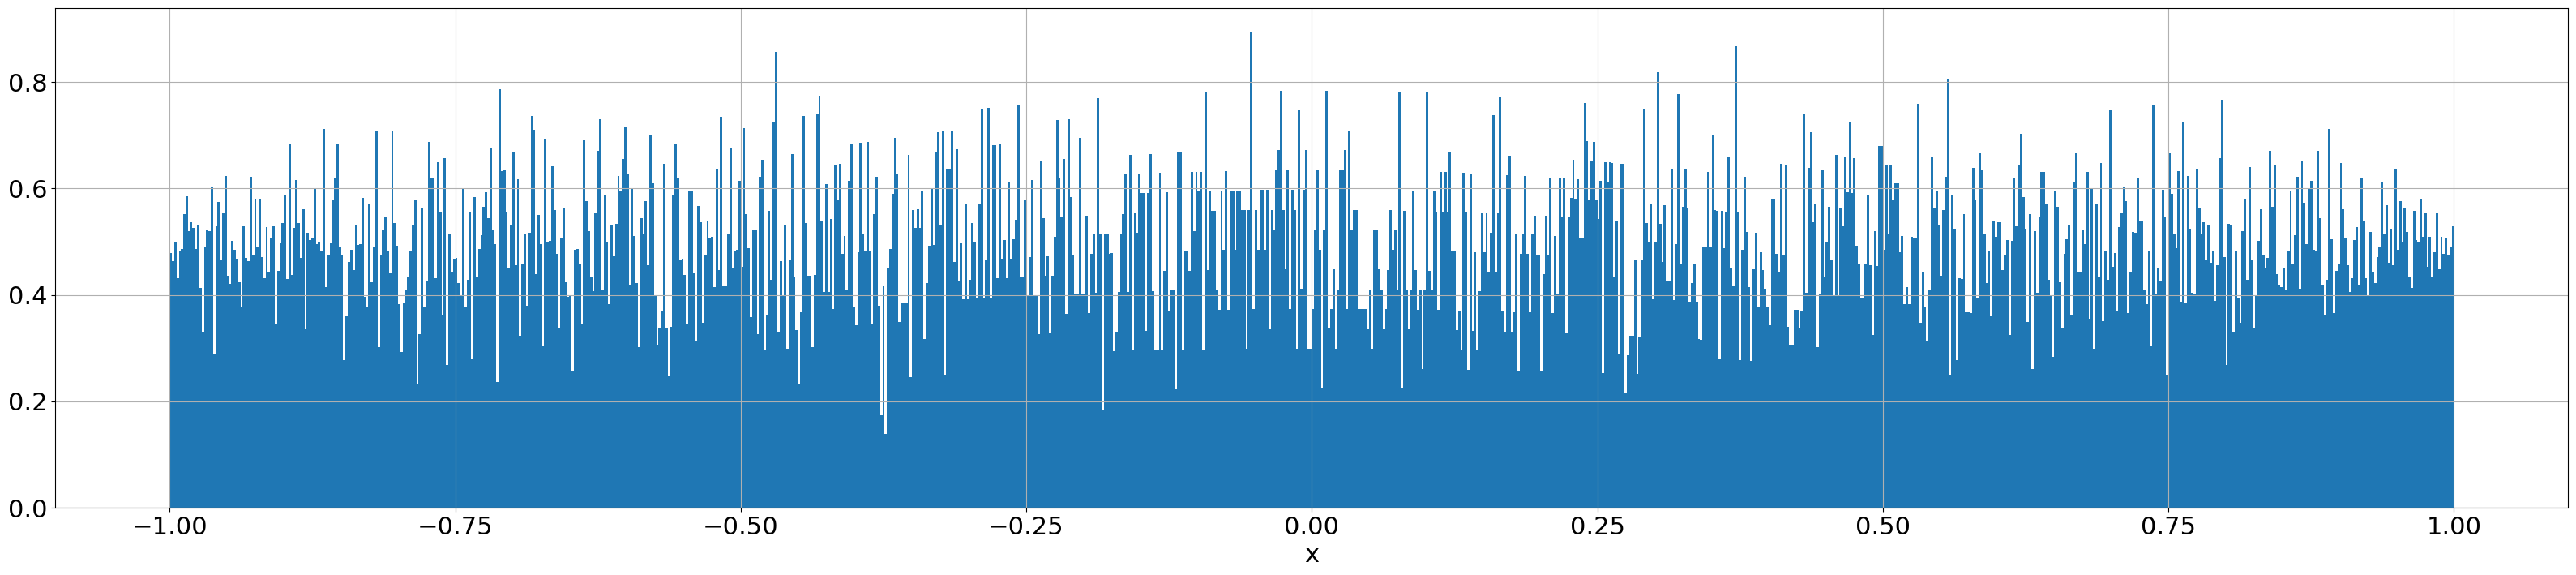

In [72]:
fig = plt.figure(figsize=(40,8))
ax = plotutil.get_ax(fig, nx=1, ny=1, idx=1, title='')
ax.hist(s, bins=1000, weights = np.pi/2 * np.sqrt(1-s**2), density=True)

plt.show()